In [67]:
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats 
import statsmodels.api as sm
import itertools
from tqdm import tqdm
import warnings
from statsmodels.sandbox.stats.multicomp import multipletests

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

import icpy

In [6]:
environments = [0.1, 1]
POPULATION = 100

data = pd.DataFrame()
data["environment"] = np.concatenate([int(POPULATION/2) * [environment] for environment in environments], axis=0)

data["x_1"] = data.apply(lambda x: np.random.normal(0, 1) * x["environment"], axis=1)
data["y"] = data.apply(lambda x: 1 * x["x_1"] + np.random.normal(0, 1), axis=1)
data["x_2"] = data.apply(lambda x: x["y"] + np.random.normal(0, 1), axis=1)

X = data[["x_1", "x_2", "environment"]].values
y = data["y"].values

In [7]:
data.head()

,environment,x_1,y,x_2
0,0.1,-0.086807,1.212190,0.475395
1,0.1,0.041669,1.202935,0.831281
2,0.1,-0.011359,-0.325850,0.342513
3,0.1,-0.055233,0.260486,-0.347295
4,0.1,0.007565,-0.762716,-0.765673


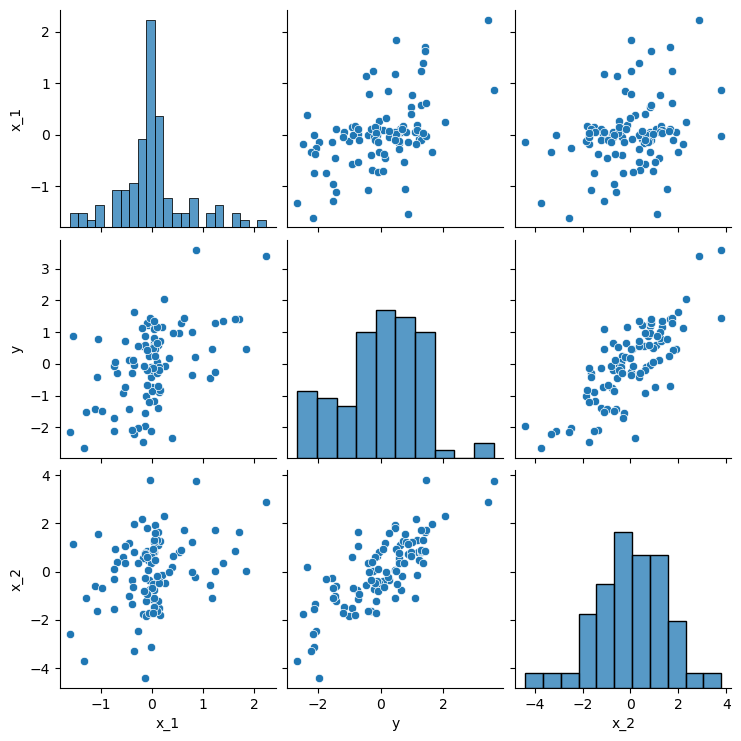

In [8]:
sns.pairplot(data.drop(["environment"], axis=1))

## Two sample t-test on the residuals of $I_e$ against $I_{-e}$

In [73]:
alpha = 0.05
feature_combs = []
E = environments  
features = ["x_1", "x_2"]

for i in range(1, 2 + 1):
  feature_combs.append(list(itertools.combinations(features, i)))

S_hat = []
for comb in tqdm(feature_combs, total=len(feature_combs), desc="Running ICP"):

  # ICP
  for S in comb:
    all_ttest = []
    all_ftest = []
    for e in E:
      # fit linear regression to all samples but fixed subset of features S
      fit_all_sample_fixed_s = sm.OLS(endog=data[["y"]], exog=data[list(S)]).fit()

      # compute residuals
      resid = fit_all_sample_fixed_s.resid
      resid_df = data[["environment"]].copy()
      resid_df["resid"] = resid

      # set Ie and Ie-
      e_minus = list(set(E) - set([e]))
      sample1 = resid_df.loc[resid_df["environment"] == e]
      sample2 = resid_df.loc[resid_df["environment"].isin(e_minus)]

      # compute t-test
      ## Asssumes 1) iid samples, 2) Normality, 3) Variance in both samples are similar
      warnings.filterwarnings("ignore") # RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
      _, ttest_pvalue = stats.ttest_ind(sample1, sample2)
      all_ttest.append(ttest_pvalue[1])

      # f-test
      ## 
      F = np.var(sample1) / np.var(sample2)
      df1 = len(sample1) - 1
      df2 = len(sample2) - 1
      ftest_pvalue = stats.f.cdf(F, df1, df2)
      all_ftest.append(ftest_pvalue[1])

    # compute bonferroni pvalue aggregation
    bonferroni_correction_ttest_pvalue = np.min([len(all_ttest) * np.min(all_ttest), 1])
    bonferroni_correction_ftest_pvalue = np.min([len(all_ftest) * np.min(all_ftest), 1])

    s_final_pvalue = np.min([2 * np.min([bonferroni_correction_ftest_pvalue, bonferroni_correction_ttest_pvalue]), 1])

    if s_final_pvalue > alpha:
      S_hat.append(S)

print("Chosen features ", S_hat)

Running ICP: 100%|██████████| 2/2 [00:00<00:00, 77.67it/s]

Chosen features  [('x_1',), ('x_2',), ('x_1', 'x_2')]


In [75]:
feature_combs

[[('x_1',), ('x_2',)], [('x_1', 'x_2')]]